In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
import numpy as np
import os
import time
import json
import pickle
from glob import glob
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
import keras as K

Using TensorFlow backend.


In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)

In [5]:
annotation_folder = '../Dataset/MSCOCO/annotations/'
image_folder = '../Dataset/MSCOCO/train2014/'

In [6]:
annotation_file = annotation_folder + 'captions_train2014.json'

# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [7]:
NUM_SAMPLES = 60


# Store captions and image names
all_captions = []
all_img_paths = []

for annot in annotations['annotations']:
    caption = "START" + annot['caption']
    image_id = annot['image_id']
    img_path = image_folder + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_paths.append(img_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
all_captions, all_img_paths = shuffle(all_captions, all_img_paths, random_state=1)
train_captions = all_captions[:NUM_SAMPLES]
train_img_paths = all_img_paths[:NUM_SAMPLES]

In [8]:
print("len train_captions :", len(train_img_paths))
print("len all_captions :", len(all_img_paths))

len train_captions : 60
len all_captions : 414113


## Encoder

In [9]:
MODEL_TYPE = "xception"


def get_encoder(model_type=MODEL_TYPE):

    if model_type == "xception":
        cnn_preprocessor = tf.keras.applications.xception
        cnn_model = tf.keras.applications.Xception(include_top=False, weights='imagenet')

    elif model_type == "inception_v3":
        cnn_preprocessor = tf.keras.applications.inception_v3
        cnn_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

    input_layer = cnn_model.input
    output_layer = cnn_model.layers[-1].output # use last hidden layer as output
    
    encoder = tf.keras.Model(input_layer, output_layer)
    encoder_preprocessor = cnn_preprocessor
    
    return encoder, encoder_preprocessor


encoder, encoder_preprocessor = get_encoder(MODEL_TYPE)

In [10]:
IMAGE_SIZE = (299, 299)


def load_image(image_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = encoder_preprocessor.preprocess_input(image)
    
    return image, image_path

## Prepare Image dataset

In [11]:
BATCH_SIZE = 8

# Get unique images
unique_train_img_paths = sorted(set(train_img_paths))

# Prepare dataset
image_dataset = tf.data.Dataset.from_tensor_slices(unique_train_img_paths)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) # use max num of CPU
image_dataset = image_dataset.batch(BATCH_SIZE)

In [12]:
estimated_batch_count = NUM_SAMPLES / BATCH_SIZE + 1
print("estimated_batch_count", estimated_batch_count)

estimated_batch_count 8.5


In [13]:
# Preprocessed image (batch)
for batch_imgs, batch_img_paths in tqdm(image_dataset):
    
    # get context vector of batch images
    batch_features = encoder(batch_imgs)
    
    # flatten 2D cnn result into 1D for RNN decoder input
    # (batch_size, 10, 10, 2048)  => (batch_size, 100, 2048)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    
    # Cache preprocessed image
    for image_feature, image_path in zip(batch_features, batch_img_paths):
        image_path = image_path.numpy().decode("utf-8")
        np.save(image_path, image_feature.numpy())

8it [00:02,  3.08it/s]


## Prepare Tokenizer

In [14]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel
from keras.preprocessing.text import Tokenizer

In [15]:
TOKENIZER = "BERT"
VOCAB_SIZE = 5000  # Choose the top-n words from the vocabulary

In [16]:
class BertTokenizerWrapper(BertTokenizer):

    def texts_to_sequences(self, texts):
        """
        convert batch texts into indexed version
        eg: ['an apple', 'two person']
        output: [[1037,17260], [2083, 2711]] 
        """
        
        tokenized_texts = [self.tokenize(x) for x in texts]
        token_ids = [self.convert_tokens_to_ids(x) for x in tokenized_texts]
        
        return token_ids

In [17]:
class TokenizerWrapper(Tokenizer):
    
    def convert_tokens_to_ids(self, tokens):
        return [self.word_index[x] for x in tokens]

In [18]:
if TOKENIZER == "BERT" :

    # Load pre-trained BERT tokenizer (vocabulary)
    tokenizer = BertTokenizerWrapper.from_pretrained('bert-base-uncased')
    
else : 
    
    # use default keras tokenizer
    tokenizer = TokenizerWrapper(num_words=VOCAB_SIZE, oov_token="[UNK]")
    tokenizer.fit_on_texts(train_captions)    
    tokenizer.word_index['[PAD]'] = 0
    tokenizer.index_word[0] = '[PAD]'

In [19]:
train_captions = tokenizer.texts_to_sequences(train_captions)

## Pad sequence

In [20]:
from keras.preprocessing.sequence import pad_sequences

# If you do not provide a max_length value, pad_sequences calculates it automatically
MAX_LENGTH = None  # use <int> or None


train_captions = pad_sequences(train_captions, maxlen=MAX_LENGTH, padding='post', truncating="post")

## Create dataset object

In [21]:
# Load the numpy files
def load_image_npy(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8') + '.npy')
    return img_tensor, cap

In [22]:
# Create dataset object
from tensorflow.data import Dataset
dataset = Dataset.from_tensor_slices((train_img_paths, train_captions))

# Use map to load the numpy files in parallel
# wrap function into numpy function
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          load_image_npy, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [23]:
# Shuffle and batch
dataset = dataset.shuffle(1000).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Split train eval test

In [24]:
# Split dataset 

TRAIN_SPLIT = 0.7
EVAL_SPLIT = 0.15
TEST_SPLIT = 0.15  # approx

n_batch = int(NUM_SAMPLES / BATCH_SIZE) + 1
n_train = int(n_batch * 0.7)
n_eval = int(n_batch * 0.15)
n_test = n_batch - (n_train + n_eval)

train_dataset = dataset.take(n_train)
eval_dataset = dataset.skip(n_train).take(n_eval)
test_dataset = dataset.skip(n_train + n_eval)


# """
# dataset => tuple of (image, captions)
# image   => (batch_size = 8, 100, 2048)
# caption => (batch_size = 8, max_length)
# """

In [25]:
print("train: {} batches, (total : {})".format(n_train, n_train * BATCH_SIZE))
print("eval : {} batches, (total : {})".format(n_eval, n_eval * BATCH_SIZE))
print("test : {} batches, (total : {} (aprx))".format(n_test, n_test * BATCH_SIZE))

train: 5 batches, (total : 40)
eval : 1 batches, (total : 8)
test : 2 batches, (total : 16 (aprx))


In [126]:
for x, y in train_dataset:
    print(y)
    break

tf.Tensor(
[[ 2707  2319  2214  3902  5013  2075  2091  1996  2346  2007  1996  4062
   5710  1012     0     0     0     0     0     0]
 [ 2707  5280 16446  1998  1037  3526  3042 10201  2006  1037  2795  1012
      0     0     0     0     0     0     0     0]
 [ 2707  2050  5629  2158  2007  1037 13555  4402  7719  1999  1996 19978
   1997  1037  4316  5129  2011 17434  1012     0]
 [ 2707  2050  5119  2003  2328  2046  1996  2217  1997  1996 28799  4330
   3578  1012     0     0     0     0     0     0]
 [ 2707  2050  5127  1997  3059  9440  3139  1999  8808  2015     0     0
      0     0     0     0     0     0     0     0]
 [ 2707  2050  5723  2007  1037 11848  1998 12509  2121  4987  2000  1996
   2813  1012     0     0     0     0     0     0]
 [ 2707  5051 27469  2551  2006 12191  7588  1999  1037  3076  7759  2282
      0     0     0     0     0     0     0     0]
 [ 2707  2102 12155  5055  2379  2028  2178  1999  1037  2492     0     0
      0     0     0     0     0     0   

# Model

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


optimizer = Adam()
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)


    """
    real => (batch_size = 8, (1))
    pred => (batch_size = 8, vocab_size)
    mask => Tensor("Cast:0", shape=(batch_size,), dtype=float32)
    loss_ => Tensor("sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(batch_size,), dtype=float32)

    return => Tensor("Mean:0", shape=(), dtype=float32)
    """

In [27]:
from tensorflow.keras.layers import Dense


class BahdanauAttention(tf.keras.Model):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
    
        """
        features (CNN_encoder output) => (batch_size, 64, embedding_dim)
        hidden                        => (batch_size, hidden_size = ??)
        
        hidden_with_time_axis => (batch_size, 1, hidden_size)
        score                 => (batch_size, 64, hidden_size)
        attention_weights     => (batch_size, 64, 1)
        context_vector (after sum) => (batch_size, hidden_size)
        """

## Encoder

In [28]:
from tensorflow.keras.layers import Dense


class CNN_Encoder(tf.keras.Model):
    
    # Image features are extracted and saved already
    # This encoder passes those features through a Fully connected layer

    def __init__(self, output_dim=256):
        super(CNN_Encoder, self).__init__()
        self.fc = Dense(output_dim, activation="relu")

    def call(self, x):
        
        x = self.fc(x)
        return x
    
        """
        return => (batch_size, 64, output_dim)
        """

## Decoder

In [270]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU
from pytorch_pretrained_bert import BertModel


WORD_EMBEDDING = "BERT"
RNN_TYPE = "LSTM"
STRATEGY = "inject"


class RNN_Decoder(tf.keras.Model):
    
    def __init__(self, rnn_type="LSTM", rnn_units=32, embedding_type="BERT", embedding_dim=256, 
                 strategy="inject", vocab_size=5000):
        
        super(RNN_Decoder, self).__init__()
        self.rnn_units = rnn_units
        self.rnn_type = rnn_type
        self.embedding_type = embedding_type
        self.strategy = strategy
        

        # embedding layer (process tokenized caption into vector)
        if self.embedding_type == "BERT":
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        else:
            self.embedding = Embedding(vocab_size, embedding_dim)
            
        
        # rnn layer for captions sequence and/or image's context vector
        if self.rnn_type == "LSTM":
            self.rnn = LSTM(self.rnn_units,
                         return_sequences=True,
                         return_state=True,
                         recurrent_initializer='glorot_uniform')
        
        elif self.rnn_type == "GRU":
            self.rnn = GRU(self.rnn_units,
                           return_sequences=True,
                           return_state=True,
                           recurrent_initializer='glorot_uniform')
        else:
            raise Exception('RNN type not supported yet (LSTM / GRU only)')
           
        
        # dense layer to choose word to generate
        self.fc1 = Dense(self.rnn_units)
        self.fc2 = Dense(vocab_size) # same size as vocab

        # attention layer for image (CNN encoder output)
        self.attention = BahdanauAttention(self.rnn_units)
        
        
    def get_embedding(self, x):
        if self.embedding_type == "BERT": 
            return self._get_bert_embedding(x)
        else:
            return self._get_default_embedding(x)
        
        
    
    def _get_bert_embedding(self, x, output_layer=11):
        """
        Get BERT's embedding for text tokens
        
        x (Text tokens) => (batch_size, 1)
        """

        # Format as torch Tensor
        x = torch.as_tensor(x.numpy())
        x = x.type(torch.LongTensor)
        
        # BERT's embedding
        with torch.no_grad():
            embedding , _ = self.bert_model(x)

        # Revert back to tf.Tensor
        x = embedding[output_layer].numpy()
        x = tf.convert_to_tensor(x)
            
        return x
    
    def _get_default_embedding(self, x):
        """
        Get default embedding for text tokens
        
        x (Text tokens) => (batch_size, 1)
        """
        return self.embedding(x)
        

    def call(self, x, features, hidden):
        """ 
        this using inject method,
        image's feature injected at every timestep 
        
        x : decoder input, also last word generated => (batch_size, 1)
        """
        
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x1 => (batch_size, 1, embedding_dim)
        x1 = self.get_embedding(x)

        
        ## TODO: inject image here ?
        ## TODO: add PPLM framework here
        ## feed-forward, find gradient, apply gradient, feed-forward again 
        

        ## Concat context vector + hidden state => inject method
        ## TODO : use merge method, pre method
        
        if self.strategy == "inject":
            # x2 => (batch_size, 1, image_feature_size + embedding_dim)
            x2 = tf.concat([tf.expand_dims(context_vector, 1), x1], axis=-1)
        else:
            x2 = x1
            
            
        # passing the concatenated vector to the RNN (LSTM / GRU)
        if self.rnn_type == "LSTM":
            output, h_state, c_state = self.rnn(x2)
            state = h_state
            
        elif self.rnn_type == "GRU":
            output, state = self.rnn(x2)
        

        ## ======================
        ## TODO: add another attention layer ? 
        ## ======================
                
        if self.strategy == "merge":
            
            # output => (batchsize = 8, 1, image_feature_size + embedding_dim)
            output = tf.concat([tf.expand_dims(context_vector, 1), output], axis=-1)
            
            # if using add instead of concat
            # output = tf.keras.layers.add([context_vector, output])

            
        # x3 shape => (batch_size, 1, rnn_units = 32)
        x3 = self.fc1(output)

        # x4 => (batch_size, rnn_units = 32)
        x4 = tf.reshape(x3, (-1, x3.shape[2]))

        
        ## TODO : merge method, concat context vector + hiddens state here .
        
        
        # word_predictions => (batch_size, vocab)
        word_predictions = self.fc2(x4)
        print("word_predictions", word_predictions.shape)
        print()
        print()

        return word_predictions, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.rnn_units))

In [271]:
# @tf.function

def train_step(img_tensor, target):
    
    loss = 0
    batch_size = target.shape[0]
    
    print("TARGET")
    print(type(target))
#     target = torch.Tensor(list(target))

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=batch_size)

    ## TODO: allow using diffrent strategy for inititalizer ? 
    ## decoder_input == last word generated
    decoder_input = tf.expand_dims(tokenizer.convert_tokens_to_ids(['start']) * batch_size, 1)

#     decoder_input = torch.tensor([tokenizer.convert_tokens_to_ids(['start'])] * batch_size)
   
    print("decoder input")
    print(type(decoder_input))

    
    with tf.GradientTape() as tape:
        
        ## Get image context vector
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            
            print("LOOP : ", i)
            
            # passing the features through the decoder
            predictions, hidden, _ = decoder(decoder_input, features, hidden)
            
            # loss => Tensor("add:0", shape=(), dtype=float32)
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            decoder_input = tf.expand_dims(target[:, i], 1)
            print("decoder_input", decoder_input.shape)
            

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss



    """
    
    decoder_input => tf.Tensor: id=11841, shape=(batch_size, 1), dtype=int32
    
    """

In [272]:
IMAGE_FEATURE_DIM = 256
WORD_EMBEDDING_DIM = 768 # BERT's embedding dim
UNITS = 32
VOCAB_SIZE = len(tokenizer.vocab.keys()) # BERT's vocab size

encoder = CNN_Encoder(
    output_dim=IMAGE_FEATURE_DIM
)

decoder = RNN_Decoder(
    rnn_type="LSTM",
    rnn_units=UNITS,
    embedding_type="BERT",
    embedding_dim=WORD_EMBEDDING_DIM,  
    vocab_size=VOCAB_SIZE
)

In [273]:
total_loss = 0

for img_tensor, target in train_dataset:
    batch_loss, t_loss = train_step(img_tensor, target)
    total_loss += t_loss
    
total_loss

TARGET
<class 'tensorflow.python.framework.ops.EagerTensor'>
decoder input
<class 'tensorflow.python.framework.ops.EagerTensor'>
LOOP :  1
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  2
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  3
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  4
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  5
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  6
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  7
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  8
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  9
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  10
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  11
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  12
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  13
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  14
word_predictions (8, 30522)


decoder_input (8, 1)
LOOP :  15
w

<tf.Tensor: id=239214, shape=(), dtype=float32, numpy=30.511932>

## Setup training

In [261]:
! rm -rf checkpoints

In [262]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [263]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [264]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

## Actual training

In [265]:
EPOCHS = 2

for epoch in range(start_epoch, EPOCHS):
    
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(train_dataset)):
        
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            
        
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

0it [00:00, ?it/s]

TARGET
<class 'tensorflow.python.framework.ops.EagerTensor'>
decoder input
<class 'tensorflow.python.framework.ops.EagerTensor'>
LOOP :  1


TypeError: _get_bert_embedding() missing 1 required positional argument: 'x'

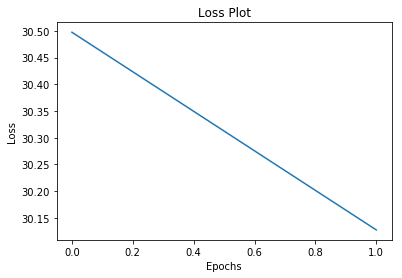

In [256]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
# @tf.function
# def eval_step(img_tensor, target):
#     """
#     basically same as train_step, but doesn't apply gradient 
#     """
    
#     loss = 0

#     # initializing the hidden state for each batch
#     # because the captions are not related from image to image
#     hidden = decoder.reset_state(batch_size=target.shape[0])

#     ## TODO: allow using diffrent strategy for inititalizer ? 
#     decoder_input = tf.expand_dims([tokenizer.word_index['[START]']] * target.shape[0], 1)
    
    
#     with tf.GradientTape() as tape:
#         features = encoder(img_tensor)

#         for i in range(1, target.shape[1]):
            
#             # passing the features through the decoder
#             predictions, hidden, _ = decoder(decoder_input, features, hidden)

#             loss += loss_function(target[:, i], predictions)
            
#             # using teacher forcing
#             decoder_input = tf.expand_dims(target[:, i], 1)

#     total_loss = (loss / int(target.shape[1]))
    
#     return loss, total_loss

In [ ]:
# ## Customized to enable multiple images, and incorporate PPLM framework


# def custom_evaluate(image, supporting_images):
    
#     attention_plot = np.zeros((max_length, attention_features_shape))

#     # initializing the hidden state for decoder
#     hidden = decoder.reset_state(batch_size=1)

#     # Extract image features
#     temp_input = tf.expand_dims(load_image(image)[0], 0)
#     img_tensor_val = image_features_extract_model(temp_input)
#     img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

#     features = encoder(img_tensor_val)
    
    
#     ## TODO: extract features from supporting images
#     ## TODO: average those features into single context vector
    
    
#     ## TODO: allow using diffrent strategy for inititalizer ? 
#     ## TODO: BERT doesn't have word_index
#     decoder_input = tf.expand_dims([tokenizer.word_index['[START]']], 0)
#     result = []

#     for i in range(max_length):
#         """
#         Currently using inject method 
#         (image feature injected at every timestep)
        
#         TODO: test merge approach & pre, par inject
#         """
        
#         ## image feature inject's method
#         predictions, hidden, attention_weights = decoder(decoder_input, features, hidden)
        
        
#         ## TODO : apply PPLM here
#         ## check loss (prediction - context vector of supporting images)
#         ## apply gradient : hidden_state += diffrence(pred, supporting img vectors) (after n-iteration)
#         ## re compute predictions
        
        
#         attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

#         predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        
        
#         ## TODO: Allow using BERT tokenizer
#         ## TODO: Revert predictions to index and words
#         result.append(tokenizer.index_word[predicted_id])   # <<< return back id to text

        
#         if tokenizer.index_word[predicted_id] == '[END]':
#             return result, attention_plot

#         decoder_input = tf.expand_dims([predicted_id], 0)

#     attention_plot = attention_plot[:len(result), :]
#     return result, attention_plot